Housekeeping

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

from matplotlib.markers import MarkerStyle

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Auxiliary functions

In [3]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    interaction = 0
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words) == 1:
            interaction = 0
            i_count = 0
        elif len(words)>1 and results_follow==1: # and words[0] not in omit_list
            if len(words)==2 and words[1]=="|":
                var_name = words[0]
                interaction = 1
                i_count = 0
            else:
                if interaction==0:
                    row_names.append(words[0])
                else:
                    row_names.append(var_name+"_"+words[0])                        
                
                if words[2]=='|':
                    t00= t0+1
                    t11 = t1+1
                else:
                    t00 = t0
                    t11 = t1

                buff_v = []
                for w in words[t00:t11]: 
                    w = w.replace(",","")
                    buff_v.append(w)
                table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

Date dictionaries

In [4]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2022):
    time_periods_thin.append(str(y))
    
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20","t21"]
period_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
    
def rename_interaction(tab,int_subs):
    tab_chunk_1 = tab.iloc[0:7].copy()
    tab_chunk_2 = tab.iloc[7:].copy()
    tab_chunk_1.rename(index=int_subs,inplace=True)
    tab = pd.concat((tab_chunk_1,tab_chunk_2))
    return tab

In [5]:
path = './results/'
ten_dist_moms = read_descriptive_stats(path+'descriptive_stats_tenure_mothers_all.log',
                       keyword_data='hub_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)
ten_dist_nomoms = read_descriptive_stats(path+'descriptive_stats_tenure_mothers_all_0k.log',
                       keyword_data='hub_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)

ten_dist_dads = read_descriptive_stats(path+'descriptive_stats_tenure_fathers_all.log',
                       keyword_data='wife_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)
ten_dist_nodads = read_descriptive_stats(path+'descriptive_stats_tenure_fathers_all_0k.log',
                       keyword_data='wife_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)

<a id='index'></a>


# Quantile regressions for tenure: coefficients by year

### Women, 35-45

Jump to
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
  - [Employment regresssions](#employment)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 --------------
 Split result tables
 --------------
 Split result tables

In [6]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_age3040_10_hemp_time_int_diff_agefix"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_age3040_hemp_time_int_diff_0k_agefix"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)


Check the table

In [7]:
tab_moms_45_25

,Coefficient,std,t,p_stat,lower_95,upper_95q25
other_ten_y,0.097025,0.002105,46.10,0.000,0.092900,0.101150
ttrend,0.032356,0.004022,8.04,0.000,0.024472,0.040239
ttrend2,-0.000627,0.000062,-10.09,0.000,-0.000749,-0.000505
sexo1#c.ttrend_1,0.041074,0.004917,8.35,0.000,0.031436,0.050711
sexo1#c.ttrend2_1,-0.000402,0.000078,-5.14,0.000,-0.000556,-0.000249
covid_1,0.337066,0.087348,3.86,0.000,0.165868,0.508265
covid_2,0.684729,0.105615,6.48,0.000,0.477726,0.891732
covid_3,1.050075,0.104376,10.06,0.000,0.845501,1.254649
1.sexo1,-0.858135,0.063697,-13.47,0.000,-0.982981,-0.733290
covid#sexo1_1,-0.271139,0.111709,-2.43,0.015,-0.490086,-0.052191


Select coefficients and standard errors

In [8]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs[q][clab]['covid#sexo1_3']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1,coef_b2))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs_0k[q][clab]['covid#sexo1_3']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1,coef_b2))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'],
                        all_tabs[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2'],
                        all_tabs[q][lowerlab]['covid#sexo1_3']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_3']) 


Plot

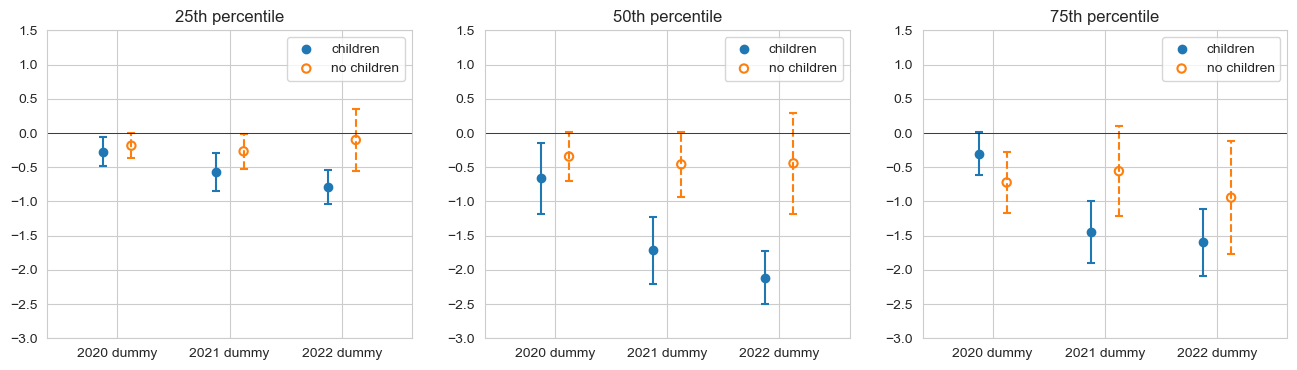

In [9]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))
mm = MarkerStyle(marker='o',fillstyle='none')

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,3),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_nochildren[q],marker=mm,color=colors[1],
                label='no children')
    plt.scatter(np.arange(0.25,3.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1],ls='--')
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3.,1.5)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.xticks([0.125,1.125,2.125],['2020 dummy','2021 dummy','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
# plt.savefig('./plots_tenure/coeffs_compare_3040.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Ages 30-35

In [10]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_3035_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_3035_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)


In [11]:
tab_moms_45_25

,Coefficient,std,t,p_stat,lower_95,upper_95q25
other_ten_y,0.079005,0.004048,19.52,0.000,0.071070,0.086940
ttrend,0.044779,0.005383,8.32,0.000,0.034228,0.055329
ttrend2,-0.000765,0.000083,-9.24,0.000,-0.000927,-0.000602
sexo1#c.ttrend_1,0.031265,0.005229,5.98,0.000,0.021016,0.041513
sexo1#c.ttrend2_1,-0.000382,0.000088,-4.36,0.000,-0.000554,-0.000211
covid_1,0.551432,0.144290,3.82,0.000,0.268626,0.834239
covid_2,0.882781,0.148024,5.96,0.000,0.592657,1.172905
1.sexo1,-0.598232,0.071120,-8.41,0.000,-0.737625,-0.458839
covid#sexo1_1,-0.253558,0.167151,-1.52,0.129,-0.581171,0.074055
covid#sexo1_2,-0.383496,0.204975,-1.87,0.061,-0.785243,0.018252


In [12]:
coeffs_children = {}
coeffs_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2']) 


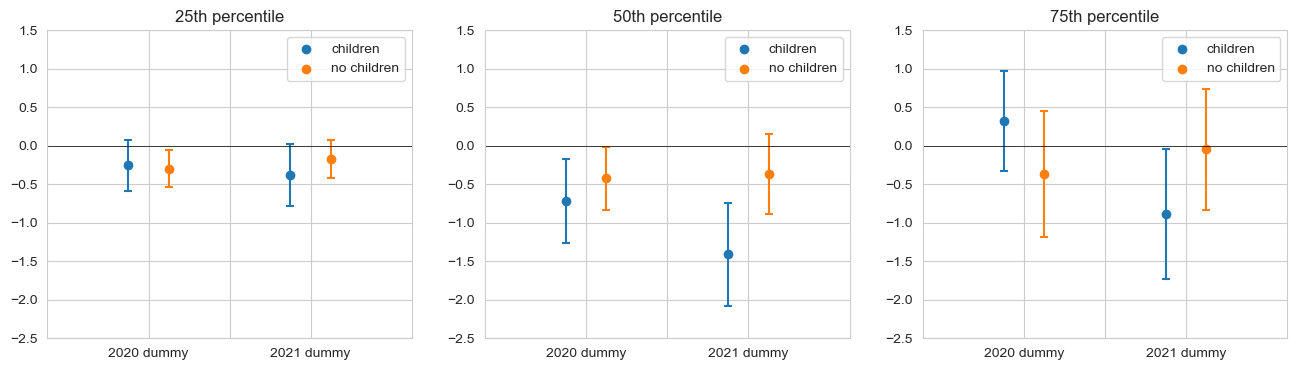

In [13]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,2),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,2),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,2),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,2.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,2.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,2.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(2):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
#     plt.legend(loc=2)
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-2.5,1.5)
    plt.xlim(-0.5,1.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125],['2020 dummy','','2021 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
#plt.savefig('./plots_tenure/coeffs_compare_controls.pdf',format='pdf',bbox_inches='tight')
plt.show()